In [1]:
from experiments.mnli_utils import *
from experiments.mnli import main, plot_Xs_and_Ys_dict
from experiments.mnli import *
from experiments.data_utils import *
# logging.basicConfig(level=logging.INFO)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [252]:
# train_instance_data_loader = get_dataloader(
#     mnli_train_dataset,
#     batch_size=1)

hans_train_instance_data_loader = get_dataloader(
    hans_train_dataset,
    batch_size=1)

hans_eval_instance_data_loader = get_dataloader(
    hans_eval_dataset,
    batch_size=1)

hans_eval_batch_data_loader = get_dataloader(
    hans_eval_dataset,
    batch_size=10000)

In [48]:
preds, label_ids, step_eval_loss = predict(trainer, task_model, hans_test_inputs)
decode_one_example(task_tokenizer, hans_eval_dataset.label_list, hans_test_inputs, torch.from_numpy(preds))

In [14]:
visualize(task_tokenizer, hans_eval_dataset.label_list, hans_test_inputs)

	P: The president advised the doctor.
	H: The doctor advised the president.
	L: non_entailment


In [49]:
# test_features = experimental_compute_BERT_CLS_feature(task_model, **hans_test_inputs)
# test_features = test_features.cpu().detach().numpy()
# KNN_distances, KNN_indices = faiss_index.search(
#     k=10000, queries=test_features)

In [55]:
print("(P: Premise, H: Hypothesis, L: Label, P: Prediction)")
print("Test Data-point")
visualize(task_tokenizer, hans_eval_dataset.label_list, hans_test_inputs)
print("\tP: entailment")

print("\nMost 3 Influential (harmful) Data-point")
visualize(task_tokenizer, hans_eval_dataset.label_list, train_inputs_collections[sorted_indices[-1]])
print()
visualize(task_tokenizer, hans_eval_dataset.label_list, train_inputs_collections[sorted_indices[-2]])
print()
visualize(task_tokenizer, hans_eval_dataset.label_list, train_inputs_collections[sorted_indices[-3]])

print("\nMost 3 Influential (helpful) Data-point")
visualize(task_tokenizer, hans_eval_dataset.label_list, train_inputs_collections[sorted_indices[1]])
print()
visualize(task_tokenizer, hans_eval_dataset.label_list, train_inputs_collections[sorted_indices[2]])
print()
visualize(task_tokenizer, hans_eval_dataset.label_list, train_inputs_collections[sorted_indices[3]])


Most 3 Influential (harmful) Data-point
	P: The artist avoided the manager that advised the scientists.
	H: The manager advised the scientists.
	L: entailment

	P: The doctor forgot that the secretaries recognized the author.
	H: The secretaries recognized the author.
	L: entailment

	P: The student avoided the lawyers who the senator recommended.
	H: The senator recommended the lawyers.
	L: entailment

Most 3 Influential (helpful) Data-point
	P: The tourist advised the bankers who the doctors contacted.
	H: The bankers advised the doctors.
	L: non_entailment

	P: The tourist near the manager advised the doctors.
	H: The manager advised the doctors.
	L: non_entailment

	P: The doctors and the student advised the secretary.
	H: The doctors advised the student.
	L: non_entailment


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

In [2]:
output_collections = torch.load("/export/home/Experiments/20200805/output_collections-hans.pt")

In [3]:
def get_Ys(x: int, label: str, heuristic: str):
    loss_dicts = [
        output_collections[label][index]["loss"]
        for index in range(len(output_collections["most-helpful"]))
    ]

    Ys = [[loss_dict[f"{x}-{1e-5}-{heuristic}"],
           loss_dict[f"{x}-{1e-4}-{heuristic}"],
           loss_dict[f"{x}-{1e-3}-{heuristic}"]]
          for loss_dict in loss_dicts]
    return Ys

In [4]:
def plot_Xs_and_Ys_dict(
        axis,
        Xs: List[float],
        Ys_dict: Dict[str, List[List[float]]],
        plot_title_label: str,
) -> None:
    color_map = {
        "helpful-1": "lightskyblue",
        "helpful-10": "deepskyblue",
        "helpful-100": "dodgerblue",
        "harmful-1": "lightcoral",
        "harmful-10": "salmon",
        "harmful-100": "red",
        "random-1": "darkgrey",
        "random-10": "dimgrey",
        "random-100": "black",
    }

    legends = []
    for tag in Ys_dict.keys():
        if tag not in color_map.keys():
            raise ValueError

        legends.append(tag)
        color = color_map[tag]
        data = np.array(Ys_dict[tag])
        is_random_data_point = "random" in tag

        if data.shape[0] != 1:
            data_mean = data.mean(axis=0)
            data_max = data.max(axis=0)
            data_min = data.min(axis=0)
            # data_std = data.std(axis=0)
            axis.plot(Xs, data_mean,
                      color=color,
                      label=tag,
                      linestyle=("--" if is_random_data_point else None))

            # axis.fill_between(Xs,
            #                   data_mean + 1. * data_std,
            #                   data_mean - 1. * data_std,
            #                   color=color,
            #                   alpha=0.1 if is_random_data_point else 0.2)
            axis.fill_between(Xs, data_max, data_min,
                              alpha=0.25,
                              color=color)
        else:
            axis.plot(Xs, data[0, ...], color=color)

    axis.set_xscale("log")
    axis.set_yscale("log")
    axis.set_xlabel("Learning Rate", fontsize=30)
    axis.set_ylabel("Loss", fontsize=30)
    axis.legend(fontsize=15)
    axis.set_title(f"Loss on HANS (Eval, {plot_title_label})", fontsize=30)
    # plt.savefig("./20200802-0.pdf")

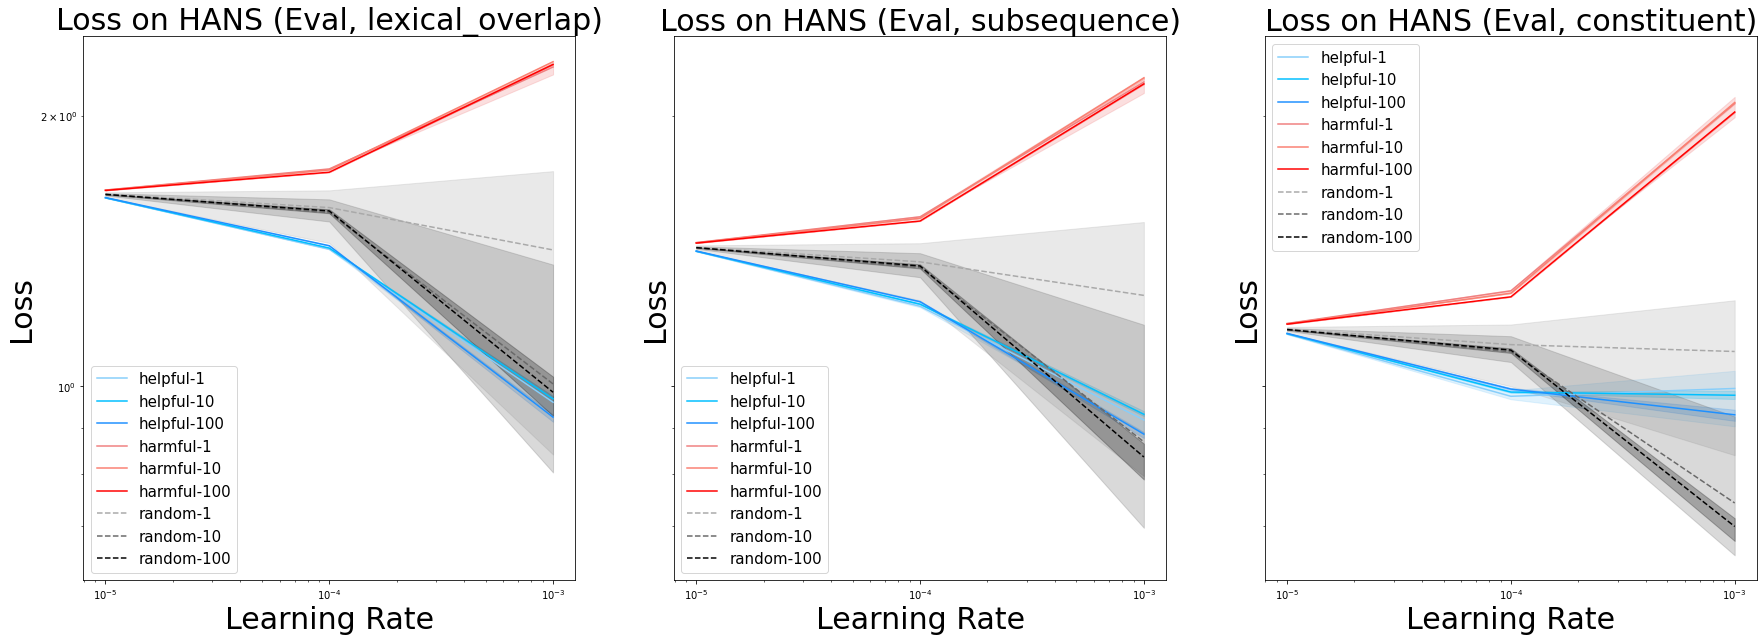

In [5]:
plt.rcParams["figure.figsize"] = (30, 10)
figure, axes = plt.subplots(1, 3, sharex=True, sharey=True)
for axis, heuristic in zip(axes, ["lexical_overlap", "subsequence", "constituent"]):
    Ys_dict = {
        "helpful-1": get_Ys(1, "most-helpful", heuristic),
        "helpful-10": get_Ys(10, "most-helpful", heuristic),
        "helpful-100": get_Ys(100, "most-helpful", heuristic),
        "harmful-1": get_Ys(1, "most-harmful", heuristic),
        "harmful-10": get_Ys(10, "most-harmful", heuristic),
        "harmful-100": get_Ys(100, "most-harmful", heuristic),
        "random-1": get_Ys(1, "random", heuristic),
        "random-10": get_Ys(10, "random", heuristic),
        "random-100": get_Ys(100, "random", heuristic),
    }
    plot_Xs_and_Ys_dict(axis, [1e-5, 1e-4, 1e-3], Ys_dict, heuristic)

In [7]:
# figure.savefig("./20200806-0.pdf")